In [96]:
!pip install optuna

DEPRECATION: Loading egg at /opt/anaconda3/lib/python3.11/site-packages/ibapi-10.30.1-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330

[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [97]:
import pandas as pd
import numpy as np
import yfinance as yf
import talib
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import holidays
import warnings
import requests
import json
from scipy import stats
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
from itertools import combinations
import optuna
from scipy.optimize import minimize
import logging
import ta  # NEW: Technical analysis indicators

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# FRED API Configuration
FRED_API_KEY = 'ac193a95a7cf1fc14f2a13ff88dd9109'
FRED_BASE_URL = 'https://api.stlouisfed.org/fred/series/observations'

print("Libraries imported successfully")

# Define assets by sector
sectors = {
    'Technology': ['AAPL', 'MSFT', 'GOOGL', 'TSLA', 'AMZN'],
    'Telecommunications': ['T', 'VZ'],
    'Shipping': ['MSC', 'FRO', 'ZIM', 'SEAC'],
    'Energy': ['XOM', 'CVX', 'BP', 'SLB'],
    'Utilities': ['NEE', 'DUK', 'ENPH', 'FSLR', 'SO'],
    'Healthcare': ['JNJ', 'PFE', 'MRK', 'ABT', 'GILD', 'BMY', 'MDT', 'AMGN', 'UNH', 'CVS'],
    'Bonds and ETFs': ['TLT', 'GLD', 'SPY', 'IVV', 'SHY', 'IEF', 'AGG', 'XLP', 'XLY', 'VTI', 'VIG']
}

start_date = datetime.strptime("2021-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2024-01-31", "%Y-%m-%d")

# Function to calculate total trading days
def calculate_trading_days(start_date, end_date):
    us_holidays = holidays.US(years=[start_date.year, end_date.year, end_date.year + 1])
    total_days = (end_date - start_date).days + 1
    trading_days = 0
    for day in (start_date + timedelta(days=i) for i in range(total_days)):
        if day.weekday() < 5 and day not in us_holidays:
            trading_days += 1
    return trading_days

# Calculate total trading days
total_trading_days = calculate_trading_days(start_date, end_date)
print(f"Total trading days from {start_date.date()} to {end_date.date()}: {total_trading_days}")

# Data Download Functions
def get_stock_data(assets):
    """Download stock data for given assets"""
    data = {}
    for asset in assets:
        try:
            df = yf.download(asset, start=start_date, end=end_date, progress=False, auto_adjust=False)
            if not df.empty:
                df = df[['Adj Close', 'Close', 'Open', 'High', 'Low', 'Volume']]
                data[asset] = df
            else:
                print(f"  {asset}: Empty data")
        except Exception as e:
            print(f"{asset}: Failed to download due to {e}")
    return data

def download_fred_data(series_id, start_date, end_date):
    """Download economic data from FRED API"""
    try:
        params = {
            'series_id': series_id,
            'api_key': FRED_API_KEY,
            'file_type': 'json',
            'observation_start': start_date.strftime('%Y-%m-%d'),
            'observation_end': end_date.strftime('%Y-%m-%d')
        }
        response = requests.get(FRED_BASE_URL, params=params)
        data = response.json()
        if 'observations' in data:
            df = pd.DataFrame(data['observations'])
            df['date'] = pd.to_datetime(df['date'])
            df['value'] = pd.to_numeric(df['value'], errors='coerce')
            df = df.set_index('date').dropna()
            return df['value']
        else:
            print(f" No data found for {series_id}")
            return pd.Series()
    except Exception as e:
        print(f"Error downloading {series_id}: {e}")
        return pd.Series()

# Download all stock data
print("Downloading stock data...")
all_tickers = [ticker for tickers in sectors.values() for ticker in tickers]
adjusted_close_data = yf.download(
    all_tickers, 
    start=start_date, 
    end=end_date,
    auto_adjust=False,
    progress=False
)['Adj Close']

sector_data = {sector: get_stock_data(assets) for sector, assets in sectors.items()}
print("Stock data downloaded successfully")

# Download FRED Economic Indicators
print("Downloading FRED economic indicators...")

fred_indicators = {
    'GS10': '10-Year Treasury Constant Maturity Rate',
    'FEDFUNDS': 'Effective Federal Funds Rate', 
    'UMCSENT': 'Consumer Sentiment Index'
}

economic_data = {}
for indicator, description in fred_indicators.items():
    print(f"   Downloading {indicator}: {description}")
    series = download_fred_data(indicator, start_date, end_date)
    if not series.empty:
        economic_data[indicator] = series
        print(f"   {indicator}: {len(series)} observations")
    else:
        print(f"   {indicator}: Failed to download")

# Create combined economic DataFrame
if economic_data:
    econ_df = pd.DataFrame(economic_data)
    econ_df = econ_df.fillna(method='ffill').dropna()
    print(f"Economic data shape: {econ_df.shape}")
else:
    print(" No economic data available, using synthetic data")
    # Create synthetic economic data as fallback
    dates = pd.date_range(start=start_date, end=end_date, freq='D')
    econ_df = pd.DataFrame({
        'GS10': np.random.normal(2.5, 0.5, len(dates)),
        'FEDFUNDS': np.random.normal(1.5, 0.3, len(dates)),
        'UMCSENT': np.random.normal(95, 10, len(dates))
    }, index=dates)

print("Economic indicators ready")

def macd_strategy(df):
    """Generate MACD signal using optimized parameters: 1 for buy, 0 for neutral"""
    macd = ta.trend.macd(df['Close'], window_slow=50, window_fast=20, window_sign=9)
    df['MACD'] = macd.macd_diff()
    df['MACD_Signal'] = np.where(df['MACD'] > 0, 1, 0)
    return df['MACD_Signal']

def ema_strategy(df):
    """Generate EMA crossover signal using optimized periods: 1 for buy, 0 for neutral"""
    ema_fast = ta.trend.ema_indicator(df['Close'], window=20).ema_indicator()
    ema_slow = ta.trend.ema_indicator(df['Close'], window=50).ema_indicator()
    df['EMA_Signal'] = np.where(ema_fast > ema_slow, 1, 0)
    return df['EMA_Signal']

print("Technical signal functions defined (MACD & EMA with optimized parameters).")


Libraries imported successfully
Total trading days from 2021-01-01 to 2024-01-31: 769
Stock data downloaded successfully
Error downloading GS10: HTTPSConnectionPool(host='api.stlouisfed.org', port=443): Max retries exceeded with url: /fred/series/observations?series_id=GS10&api_key=ac193a95a7cf1fc14f2a13ff88dd9109&file_type=json&observation_start=2021-01-01&observation_end=2024-01-31 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x169073a50>: Failed to resolve 'api.stlouisfed.org' ([Errno 8] nodename nor servname provided, or not known)"))
   GS10: Failed to download
Error downloading FEDFUNDS: HTTPSConnectionPool(host='api.stlouisfed.org', port=443): Max retries exceeded with url: /fred/series/observations?series_id=FEDFUNDS&api_key=ac193a95a7cf1fc14f2a13ff88dd9109&file_type=json&observation_start=2021-01-01&observation_end=2024-01-31 (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x1693a4250>: Failed to resolve 'api.stlou

# Cointegration Analysis Functions

In [98]:
class CointegrationAnalyzer:#Class for cointegration analysis and pair validation.
    
    def __init__(self, significance_level=0.05):
        self.significance_level = significance_level
        
    def test_cointegration(self, series1, series2):#Testing cointegration between two price series.
        try:
            # Align series
            combined = pd.concat([series1, series2], axis=1).dropna()
            if len(combined) < 30:  # Minimum observations
                return False, np.nan, np.nan
                
            s1, s2 = combined.iloc[:, 0], combined.iloc[:, 1]
            
            # Engle-Granger cointegration test
            score, p_value, _ = coint(s1, s2)
            
            # ADF test on residuals
            ols_result = stats.linregress(s1, s2)
            residuals = s2 - (ols_result.intercept + ols_result.slope * s1)
            adf_stat, adf_p_value, _, _, _, _ = adfuller(residuals)
            
            is_cointegrated = p_value < self.significance_level and adf_p_value < self.significance_level
            
            return is_cointegrated, p_value, adf_p_value
            
        except Exception as e:
            print(f"Cointegration test error: {e}")
            return False, np.nan, np.nan
    
    def find_cointegrated_pairs(self, price_data, min_correlation=0.3):
        """Find all cointegrated pairs from price data"""
        tickers = list(price_data.columns)
        cointegrated_pairs = []
        
        print(f"🔍 Testing {len(list(combinations(tickers, 2)))} potential pairs...")
        
        for ticker1, ticker2 in combinations(tickers, 2):
            if ticker1 in price_data.columns and ticker2 in price_data.columns:
                series1 = price_data[ticker1].dropna()
                series2 = price_data[ticker2].dropna()
                
                # Check minimum correlation
                correlation = series1.corr(series2)
                if abs(correlation) < min_correlation:
                    continue
                
                is_coint, p_val, adf_p = self.test_cointegration(series1, series2)
                
                if is_coint:
                    # Get sector information
                    sector1 = self.get_ticker_sector(ticker1)
                    sector2 = self.get_ticker_sector(ticker2)
                    is_cross_sector = sector1 != sector2
                    
                    cointegrated_pairs.append({
                        'ticker1': ticker1,
                        'ticker2': ticker2,
                        'sector1': sector1,
                        'sector2': sector2,
                        'cross_sector': is_cross_sector,
                        'correlation': correlation,
                        'coint_p_value': p_val,
                        'adf_p_value': adf_p
                    })
        
        pairs_df = pd.DataFrame(cointegrated_pairs)
        print(f"Found {len(pairs_df)} cointegrated pairs")
        if len(pairs_df) > 0:
            print(f"   Cross-sector pairs: {pairs_df['cross_sector'].sum()}")
            print(f"   Same-sector pairs: {(~pairs_df['cross_sector']).sum()}")
        
        return pairs_df
    
    def get_ticker_sector(self, ticker):
        """Get sector for a given ticker"""
        for sector, tickers in sectors.items():
            if ticker in tickers:
                return sector
        return 'Unknown'

# Initialize cointegration analyzer
coint_analyzer = CointegrationAnalyzer()

# Find cointegrated pairs
print("Analyzing cointegration relationships...")
cointegrated_pairs = coint_analyzer.find_cointegrated_pairs(adjusted_close_data)

if len(cointegrated_pairs) > 0:
    print(f"\n Top 5 cointegrated pairs by correlation:")
    display_cols = ['ticker1', 'ticker2', 'cross_sector', 'correlation', 'coint_p_value']
    print(cointegrated_pairs.nlargest(5, 'correlation')[display_cols])
else:
    print(" No cointegrated pairs found, using synthetic pairs for demonstration")


Analyzing cointegration relationships...
🔍 Testing 820 potential pairs...
Found 35 cointegrated pairs
   Cross-sector pairs: 35
   Same-sector pairs: 0

 Top 5 cointegrated pairs by correlation:
   ticker1 ticker2  cross_sector  correlation  coint_p_value
14      BP     MRK          True     0.917498       0.005800
9      AGG     MDT          True     0.916738       0.036814
22     IEF     MDT          True     0.915938       0.016982
30    SEAC     TLT          True     0.886367       0.000806
23     IEF    SEAC          True     0.864087       0.012684


In [99]:
class PairsTradingSignals:#Generate trading signals for pairs trading strategy.

    def __init__(self, lookback_window=90, z_entry_threshold=2.5, z_exit_threshold=1.0):
        self.lookback_window = lookback_window
        self.z_entry_threshold = z_entry_threshold
        self.z_exit_threshold = z_exit_threshold

    def calculate_spread_features(self, price1, price2, econ_data=None):
        combined = pd.concat([price1, price2], axis=1).dropna()
        if len(combined) < self.lookback_window * 2:
            print("Not enough data to compute features.")
            return pd.DataFrame()

        print(f"✅ Data aligned. Number of rows after dropping NA: {len(combined)}")

        p1, p2 = combined.iloc[:, 0], combined.iloc[:, 1]

        # Rolling OLS for hedge ratio
        rolling_ols = RollingOLS(
            p2, pd.concat([pd.Series(1, index=p1.index), p1], axis=1), 
            window=self.lookback_window
        ).fit()

        hedge_ratios = rolling_ols.params.iloc[:, 1]
        intercepts = rolling_ols.params.iloc[:, 0]

        spread = p2 - (intercepts + hedge_ratios * p1)
        spread_mean = spread.rolling(self.lookback_window).mean()
        spread_std = spread.rolling(self.lookback_window).std()
        z_score = (spread - spread_mean) / spread_std

        features_df = pd.DataFrame({
            'price1': p1,
            'price2': p2,
            'spread': spread,
            'z_score': z_score,
            'hedge_ratio': hedge_ratios,
            'spread_ma': spread_mean,
            'spread_std': spread_std,
            'correlation': p1.rolling(self.lookback_window).corr(p2),
            'volatility1': p1.pct_change().rolling(self.lookback_window).std(),
            'volatility2': p2.pct_change().rolling(self.lookback_window).std(),
            'momentum1': p1.pct_change(10),
            'momentum2': p2.pct_change(10),
            'rsi1': self.calculate_rsi(p1, window=21),  # longer RSI
            'rsi2': self.calculate_rsi(p2, window=21)
        })

        if econ_data is not None and not econ_data.empty:
            econ_aligned = econ_data.reindex(features_df.index, method='ffill')
            for col in econ_data.columns:
                features_df[f'econ_{col}'] = econ_aligned[col]
            print(f" Economic indicators added: {list(econ_data.columns)}")

        features_df = features_df.dropna()
        print(f" Feature DataFrame created. Shape: {features_df.shape}")
        return features_df

    def calculate_rsi(self, prices, window=21):
        try:
            rsi = talib.RSI(prices.values.astype(float), timeperiod=window)
            return pd.Series(rsi, index=prices.index)
        except Exception as e:
            print(f" TALib RSI failed. Using fallback method. Error: {e}")
            delta = prices.diff()
            gain = delta.where(delta > 0, 0).rolling(window=window).mean()
            loss = -delta.where(delta < 0, 0).rolling(window=window).mean()
            rs = gain / loss
            return 100 - (100 / (1 + rs))

    def generate_trading_signals(self, features_df, dynamic_threshold=False):
        signals = pd.DataFrame(index=features_df.index)
        z_score = features_df['z_score']

        if dynamic_threshold and any(col.startswith('econ_') for col in features_df.columns):
            if 'econ_GS10' in features_df.columns:
                vol_adjustment = (features_df['econ_GS10'] - features_df['econ_GS10'].mean()) / features_df['econ_GS10'].std()
                entry_threshold = self.z_entry_threshold + vol_adjustment * 0.5
                exit_threshold = self.z_exit_threshold + vol_adjustment * 0.1
                print("Using dynamic thresholds based on GS10")
            else:
                entry_threshold = self.z_entry_threshold
                exit_threshold = self.z_exit_threshold
        else:
            entry_threshold = self.z_entry_threshold
            exit_threshold = self.z_exit_threshold

        # More conservative correlation filter
        long_entry = (z_score < -entry_threshold) & (features_df['correlation'] > 0.5)
        short_entry = (z_score > entry_threshold) & (features_df['correlation'] > 0.5)

        long_exit = (z_score > -exit_threshold) | (z_score > entry_threshold)
        short_exit = (z_score < exit_threshold) | (z_score < -entry_threshold)

        position = pd.Series(0, index=features_df.index)

        for i in range(1, len(position)):
            prev_pos = position.iloc[i - 1]
            if prev_pos == 0:
                if long_entry.iloc[i]:
                    position.iloc[i] = 1
                elif short_entry.iloc[i]:
                    position.iloc[i] = -1
            elif prev_pos == 1:
                if long_exit.iloc[i]:
                    position.iloc[i] = 0
                else:
                    position.iloc[i] = 1
            elif prev_pos == -1:
                if short_exit.iloc[i]:
                    position.iloc[i] = 0
                else:
                    position.iloc[i] = -1

        signals['position'] = position
        signals['z_score'] = z_score
        signals['entry_threshold'] = entry_threshold if isinstance(entry_threshold, (int, float)) else entry_threshold
        signals['exit_threshold'] = exit_threshold if isinstance(exit_threshold, (int, float)) else exit_threshold

        print(f"Signals generated. Non-zero positions: {signals['position'].ne(0).sum()}")
        return signals

# Initialize updated conservative signal generator
signal_generator = PairsTradingSignals()
print("Pairs trading signal generator initialized")


Pairs trading signal generator initialized


# Machine Learning Features and Model Training

In [100]:
class MLTradingSignals:
    def __init__(self):
        self.rf_model = None
        self.svm_model = None
        self.scaler = StandardScaler()
        self.feature_columns = None
        
    def prepare_ml_features(self, features_df, forward_returns_days=5):
        ml_features = features_df.copy()
        
        # Technical indicators
        ml_features['spread_momentum'] = ml_features['spread'].pct_change(5)
        ml_features['z_score_ma'] = ml_features['z_score'].rolling(15).mean()  # more smoothing
        ml_features['volatility_ratio'] = ml_features['volatility1'] / ml_features['volatility2']
        ml_features['price_ratio'] = ml_features['price1'] / ml_features['price2']
        ml_features['correlation_change'] = ml_features['correlation'].diff()
        
        # Lagged features
        for lag in [1, 3, 5]:
            ml_features[f'z_score_lag_{lag}'] = ml_features['z_score'].shift(lag)
            ml_features[f'spread_lag_{lag}'] = ml_features['spread'].shift(lag)
        
        # Forward returns for target variable
        ml_features['forward_spread_return'] = ml_features['spread'].shift(-forward_returns_days) - ml_features['spread']
        
        # Target variable: 1 if profitable trade, 0 otherwise
        ml_features['target'] = (
            (ml_features['z_score'] < -2) & (ml_features['forward_spread_return'] > 0) |
            (ml_features['z_score'] > 2) & (ml_features['forward_spread_return'] < 0)
        ).astype(int)
        
        return ml_features.dropna()
    
    def train_models(self, features_df, test_size=0.3):
        ml_data = self.prepare_ml_features(features_df)
        
        if len(ml_data) < 100:
            print("Insufficient data for ML training")
            return False
        
        feature_cols = [col for col in ml_data.columns 
                        if col not in ['target', 'forward_spread_return', 'price1', 'price2']]
        
        X = ml_data[feature_cols]
        y = ml_data['target']
        
        X = X.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')
        
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )
        
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        # Train Random Forest
        print("Training Random Forest...")
        self.rf_model = RandomForestClassifier(
            n_estimators=100,
            max_depth=10,
            min_samples_split=10,
            random_state=42,
            class_weight='balanced'
        )
        self.rf_model.fit(X_train_scaled, y_train)
        
        # Train SVM
        print("Training SVM...")
        self.svm_model = SVC(
            kernel='rbf',
            C=1.0,
            gamma='scale',
            probability=True,
            random_state=42,
            class_weight='balanced'
        )
        self.svm_model.fit(X_train_scaled, y_train)
        
        # Evaluation
        rf_train_score = self.rf_model.score(X_train_scaled, y_train)
        rf_test_score = self.rf_model.score(X_test_scaled, y_test)
        svm_train_score = self.svm_model.score(X_train_scaled, y_train)
        svm_test_score = self.svm_model.score(X_test_scaled, y_test)
        
        print(f"Random Forest - Train: {rf_train_score:.3f}, Test: {rf_test_score:.3f}")
        print(f"SVM - Train: {svm_train_score:.3f}, Test: {svm_test_score:.3f}")
        
        if hasattr(self.rf_model, 'feature_importances_'):
            feature_importance = pd.DataFrame({
                'feature': feature_cols,
                'importance': self.rf_model.feature_importances_
            }).sort_values('importance', ascending=False)
            print("\n🔍 Top 5 Important Features:")
            print(feature_importance.head())
        
        self.feature_columns = feature_cols
        return True
    
    def predict_signals(self, features_df):
        """Generate ML-based trading signals"""
        if self.rf_model is None or self.svm_model is None:
            return pd.Series(0, index=features_df.index)
        
        ml_data = self.prepare_ml_features(features_df)
        if len(ml_data) == 0:
            return pd.Series(0, index=features_df.index)
        
        X = ml_data[self.feature_columns]
        X = X.replace([np.inf, -np.inf], np.nan).fillna(method='ffill').fillna(method='bfill')
        X_scaled = self.scaler.transform(X)
        
        rf_proba = self.rf_model.predict_proba(X_scaled)[:, 1]
        svm_proba = self.svm_model.predict_proba(X_scaled)[:, 1]
        ensemble_proba = (rf_proba + svm_proba) / 2
        
        threshold = 1.5  # 🔷 More conservative threshold marker
        ml_signals = pd.Series(0, index=ml_data.index)
        ml_signals[ensemble_proba > 0.7] = 1   # Only act on stronger confidence
        ml_signals[ensemble_proba < 0.3] = -1  # Only act on strong sell signal
        
        return ml_signals.reindex(features_df.index, fill_value=0)

# Initialize ML signal generator
ml_signals = MLTradingSignals()
print("✅ ML trading signals module initialized")


✅ ML trading signals module initialized


# Risk Management and Position Sizing

In [101]:
class RiskManager:   
    def __init__(self, max_leverage=2.0, max_single_position=0.1, vol_target=0.15):
        self.max_leverage = max_leverage
        self.max_single_position = max_single_position
        self.vol_target = vol_target
        self.max_drawdown_limit = 0.2
        
    def calculate_kelly_fraction(self, returns):
        if len(returns) < 30:
            return 0.1  # Conservative default
        
        mean_return = returns.mean()
        variance = returns.var()
        
        if variance <= 0:
            return 0.1
        
        kelly_fraction = mean_return / variance
        
        # Apply conservative scaling (25% of full Kelly)
        conservative_kelly = kelly_fraction * 0.25
        
        # Cap at maximum single position
        return min(abs(conservative_kelly), self.max_single_position)
    
    def calculate_volatility_target_size(self, returns, target_vol=None):
        if target_vol is None:
            target_vol = self.vol_target
            
        if len(returns) < 10:
            return 0.1
        
        current_vol = returns.std() * np.sqrt(252)  # Annualized volatility
        
        if current_vol <= 0:
            return 0.1
        
        vol_scalar = target_vol / current_vol
        return min(vol_scalar, self.max_single_position)
    
    def calculate_position_size(self, returns, method='kelly'):
        if len(returns) < 10:
            return 0.05  # Minimum position size
        
        if method == 'kelly':
            size = self.calculate_kelly_fraction(returns)
        elif method == 'vol_target':
            size = self.calculate_volatility_target_size(returns)
        else:
            size = min(0.1, self.max_single_position)  # Default
        
        return np.clip(size, 0.01, self.max_single_position)
    
    def calculate_var_cvar(self, returns, confidence_level=0.05):
        if len(returns) < 30:
            return np.nan, np.nan
        
        var = np.percentile(returns, confidence_level * 100)
        cvar = returns[returns <= var].mean()
        
        return var, cvar
    
    def check_risk_limits(self, portfolio_value, peak_value):
        current_drawdown = (peak_value - portfolio_value) / peak_value
        
        if current_drawdown > self.max_drawdown_limit:
            return False, f"Maximum drawdown exceeded: {current_drawdown:.2%}"
        
        return True, "Risk limits OK"

# Initialize risk manager
risk_manager = RiskManager()
print("✅Risk management module initialized")


✅Risk management module initialized


# Transaction Cost and Slippage Modeling (Conservative)


In [102]:
class TransactionCostModel:#Model transaction costs and market impact with conservative sizing
    
    def __init__(self, fixed_cost=1.0, percentage_cost=0.001, slippage_rate=0.0005):
        self.fixed_cost = fixed_cost            # Fixed cost per trade (e.g., commission)
        self.percentage_cost = percentage_cost  # Percentage of trade value (e.g., 0.1%)
        self.slippage_rate = slippage_rate      # Market impact slippage (e.g., 0.05%)
        self.position_size_factor = 0.5         #  Reduced to 50% of full size
    
    def calculate_transaction_cost(self, trade_value, trade_size):
        adjusted_trade_value = trade_value * self.position_size_factor
        adjusted_trade_size = trade_size * self.position_size_factor
        
        fixed_component = self.fixed_cost
        percentage_component = abs(adjusted_trade_value) * self.percentage_cost
        slippage_component = abs(adjusted_trade_value) * self.slippage_rate
        
        total_cost = fixed_component + percentage_component + slippage_component
        return total_cost
    
    def apply_slippage(self, execution_price, trade_direction, volatility=0.02):
        # trade_direction: 1 = buy, -1 = sell
        base_slippage = self.slippage_rate
        vol_adjustment = volatility * 0.5
        
        total_slippage = base_slippage + vol_adjustment
        slippage_factor = 1 + (trade_direction * total_slippage)
        
        return execution_price * slippage_factor

# Initialize conservative transaction cost model
cost_model = TransactionCostModel()
print("✅ Transaction cost model initialized (conservative position sizing)")


✅ Transaction cost model initialized (conservative position sizing)


# Completed Pairs Trading Strategy


In [103]:
class PairsTradingStrategy:
    def __init__(self, initial_capital=100000):
        self.initial_capital = initial_capital
        self.current_capital = initial_capital
        self.positions = {}
        self.trades = []
        self.portfolio_values = []
        self.performance_metrics = {}
        
    def backtest_pair(self, ticker1, ticker2, price_data, economic_data=None, use_ml=True):
        if ticker1 not in price_data.columns or ticker2 not in price_data.columns:
            print(f"Missing data for pair {ticker1}/{ticker2}")
            return pd.DataFrame()
        
        price1 = price_data[ticker1].dropna()
        price2 = price_data[ticker2].dropna()
        
        # Calculate features
        features = signal_generator.calculate_spread_features(price1, price2, economic_data)
        
        if len(features) < 100:
            print(f"Insufficient data for {ticker1}/{ticker2}")
            return pd.DataFrame()
        
        # Generate base signals
        base_signals = signal_generator.generate_trading_signals(features, dynamic_threshold=True)
        
        # Generate ML signals if requested
        if use_ml:
            train_size = int(len(features) * 0.7)
            train_features = features.iloc[:train_size]
            
            if ml_signals.train_models(train_features):
                ml_signal_series = ml_signals.predict_signals(features)
                combined_signals = base_signals['position'] * 0.6 + ml_signal_series * 0.4
                combined_signals = combined_signals.apply(lambda x: 1 if x > 0.5 else (-1 if x < -0.5 else 0))
            else:
                combined_signals = base_signals['position']
        else:
            combined_signals = base_signals['position']
        
        # Calculate returns
        spread_returns = features['spread'].pct_change().fillna(0)
        position_returns = combined_signals.shift(1) * spread_returns
        
        # Risk management
        position_sizes = []
        for i in range(len(position_returns)):
            if i < 30:
                size = 0.05
            else:
                recent_returns = position_returns.iloc[max(0, i-30):i]
                size = risk_manager.calculate_position_size(recent_returns, method='kelly')
            position_sizes.append(size)
        
        position_sizes = pd.Series(position_sizes, index=position_returns.index)
        
        # Apply position sizing
        scaled_returns = position_returns * position_sizes
        
        # Calculate transaction costs
        position_changes = combined_signals.diff().fillna(0)
        trade_costs = []
        
        for i, change in enumerate(position_changes):
            if abs(change) > 0:
                trade_value = features.iloc[i]['price1'] * position_sizes.iloc[i] * 100
                cost = cost_model.calculate_transaction_cost(trade_value, abs(change))
                trade_costs.append(cost / self.initial_capital)
            else:
                trade_costs.append(0)
        
        trade_costs = pd.Series(trade_costs, index=position_returns.index)
        
        # Net returns after costs
        net_returns = scaled_returns - trade_costs
        
        # Create results DataFrame
        results = pd.DataFrame({
            'price1': features['price1'],
            'price2': features['price2'],
            'spread': features['spread'],
            'z_score': features['z_score'],
            'position': combined_signals,
            'position_size': position_sizes,
            'returns': position_returns,
            'scaled_returns': scaled_returns,
            'transaction_costs': trade_costs,
            'net_returns': net_returns,
            'cumulative_returns': (1 + net_returns).cumprod()
        })
        
        return results
    
    def run_full_backtest(self, pairs_df, price_data, economic_data=None, max_pairs=10):
        """Run backtest on multiple pairs"""
        
        if len(pairs_df) == 0:
            print("No pairs to backtest")
            return
        
        selected_pairs = pairs_df.nlargest(max_pairs, 'correlation')
        
        print(f"Running backtest on {len(selected_pairs)} pairs...")
        
        all_results = {}
        portfolio_returns = pd.Series(dtype=float)
        
        for idx, pair in selected_pairs.iterrows():
            ticker1, ticker2 = pair['ticker1'], pair['ticker2']
            print(f"Backtesting {ticker1}/{ticker2}...")
            
            pair_results = self.backtest_pair(ticker1, ticker2, price_data, economic_data)
            
            if not pair_results.empty:
                all_results[f"{ticker1}_{ticker2}"] = pair_results
                
                if portfolio_returns.empty:
                    portfolio_returns = pair_results['net_returns'] / len(selected_pairs)
                else:
                    aligned_returns = pair_results['net_returns'].reindex(portfolio_returns.index, fill_value=0)
                    portfolio_returns += aligned_returns / len(selected_pairs)
        
        if portfolio_returns.empty:
            print("No successful backtests")
            return
        
        self.calculate_performance_metrics(portfolio_returns)
        
        self.all_results = all_results
        self.portfolio_returns = portfolio_returns
        self.portfolio_cumulative = (1 + portfolio_returns).cumprod()
        
        print("Backtest completed successfully")
        
    def calculate_performance_metrics(self, returns):# Calculating comprehensive performance metrics (excludes VaR/CVaR).
        if len(returns) == 0:
            return
        
        total_return = (1 + returns).prod() - 1
        annualized_return = (1 + returns.mean()) ** 252 - 1
        volatility = returns.std() * np.sqrt(252)
        sharpe_ratio = annualized_return / volatility if volatility > 0 else 0
        
        cumulative = (1 + returns).cumprod()
        rolling_max = cumulative.expanding().max()
        drawdowns = (cumulative - rolling_max) / rolling_max
        max_drawdown = drawdowns.min()
        
        downside_returns = returns[returns < 0]
        downside_deviation = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
        sortino_ratio = annualized_return / downside_deviation if downside_deviation > 0 else 0
        
        calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
        
        winning_trades = returns[returns > 0]
        win_rate = len(winning_trades) / len(returns) if len(returns) > 0 else 0
        
        self.performance_metrics = {
            'Total Return': total_return,
            'Annualized Return': annualized_return,
            'Volatility': volatility,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Calmar Ratio': calmar_ratio,
            'Max Drawdown': max_drawdown,
            'Win Rate': win_rate,
            'Total Trades': len(returns[returns != 0])
        }
    
    def print_performance_summary(self):
        """Print performance summary"""
        if not self.performance_metrics:
            print("No performance metrics available")
            return
        
        print("\n" + "="*50)
        print("STRATEGY PERFORMANCE SUMMARY")
        print("="*50)
        
        for metric, value in self.performance_metrics.items():
            if isinstance(value, float):
                if 'Rate' in metric or 'Return' in metric or 'Drawdown' in metric:
                    print(f"{metric:<20}: {value:>8.2%}")
                elif 'Ratio' in metric:
                    print(f"{metric:<20}: {value:>8.2f}")
                else:
                    print(f"{metric:<20}: {value:>8.4f}")
            else:
                print(f"{metric:<20}: {value:>8}")

# Initialize strategy
strategy = PairsTradingStrategy(initial_capital=100000)
print("Pairs trading strategy initialized")


Pairs trading strategy initialized


# Hyperparameter Optimization with Optuna


In [104]:
class HyperparameterOptimizer:    
    def __init__(self, price_data, economic_data=None):
        self.price_data = price_data
        self.economic_data = economic_data
        
    def objective(self, trial):
        z_entry_threshold = trial.suggest_float('z_entry_threshold', 1.5, 3.0)
        z_exit_threshold = trial.suggest_float('z_exit_threshold', 0.3, 1.0)
        lookback_window = trial.suggest_int('lookback_window', 30, 120)
        max_leverage = trial.suggest_float('max_leverage', 1.0, 3.0)
        vol_target = trial.suggest_float('vol_target', 0.1, 0.3)
        
        try:
            temp_signal_generator = PairsTradingSignals(
                lookback_window=lookback_window,
                z_entry_threshold=z_entry_threshold,
                z_exit_threshold=z_exit_threshold
            )
            
            temp_risk_manager = RiskManager(
                max_leverage=max_leverage,
                vol_target=vol_target
            )
            
            # Quick backtest on a subset of pairs
            if len(cointegrated_pairs) > 0:
                test_pair = cointegrated_pairs.iloc[0]
                ticker1, ticker2 = test_pair['ticker1'], test_pair['ticker2']
                
                if ticker1 in self.price_data.columns and ticker2 in self.price_data.columns:
                    price1 = self.price_data[ticker1].dropna()
                    price2 = self.price_data[ticker2].dropna()
                    
                    features = temp_signal_generator.calculate_spread_features(
                        price1, price2, self.economic_data
                    )
                    
                    if len(features) > 100:
                        signals = temp_signal_generator.generate_trading_signals(features)
                        
                        # ✅ Smooth position: 3-day moving average of signals
                        positions = signals.rolling(window=3).mean().shift(1).fillna(0)
                        returns = features['spread'].pct_change()
                        
                        strategy_returns = positions * returns
                        
                        # Calculate Sharpe ratio as optimization target
                        if strategy_returns.std() > 0:
                            sharpe = strategy_returns.mean() / strategy_returns.std() * np.sqrt(252)
                            return sharpe
            
            return -1  # Return negative value if backtest fails
            
        except Exception:
            return -1  # Return negative value on error
    
    def optimize(self, n_trials=50):        
        print(f"🔧 Starting hyperparameter optimization with {n_trials} trials...")
        
        try:
            import optuna
            optuna.logging.set_verbosity(optuna.logging.WARNING)
            
            study = optuna.create_study(direction='maximize')
            study.optimize(self.objective, n_trials=n_trials)
            
            print("Optimization completed!")
            print(f"Best Sharpe Ratio: {study.best_value:.3f}")
            print( "Best Parameters:")
            for param, value in study.best_params.items():
                print(f"   {param}: {value}")
            
            return study.best_params
            
        except ImportError:
            print("Optuna not available, using GridSearchCV fallback...")
            return self.grid_search_fallback()
        except Exception as e:
            print(f"Optimization failed: {e}")
            return None
    
    def grid_search_fallback(self):
        """Fallback optimization using GridSearchCV"""
        
        param_grid = {
            'z_entry_threshold': [1.5, 2.0, 2.5],
            'z_exit_threshold': [0.3, 0.5, 0.7],
            'lookback_window': [30, 60, 90]
        }
        
        best_params = None
        best_score = -np.inf
        
        print("🔍 Running grid search...")
        
        for z_entry in param_grid['z_entry_threshold']:
            for z_exit in param_grid['z_exit_threshold']:
                for lookback in param_grid['lookback_window']:
                    
                    params = {
                        'z_entry_threshold': z_entry,
                        'z_exit_threshold': z_exit, 
                        'lookback_window': lookback,
                        'max_leverage': 2.0,
                        'vol_target': 0.15
                    }
                    
                    # Quick test
                    score = self.test_parameters(params)
                    
                    if score > best_score:
                        best_score = score
                        best_params = params
        
        print(f"Grid search completed! Best score: {best_score:.3f}")
        return best_params
    
    def test_parameters(self, params):
        try:
            # Quick implementation for testing
            return np.random.normal(0.5, 0.2)  # Placeholder
        except:
            return -1

# Initialize optimizer (if we have pairs)
if len(cointegrated_pairs) > 0:
    optimizer = HyperparameterOptimizer(adjusted_close_data, econ_df)
    print("Hyperparameter optimizer initialized")
else:
    print("Skipping optimization - no cointegrated pairs found")


Hyperparameter optimizer initialized


In [105]:
class StrategyVisualizer:    
    def __init__(self):
        plt.style.use('seaborn-v0_8')
        
    def plot_pair_analysis(self, results_df, ticker1, ticker2):
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(f'Pairs Trading Analysis: {ticker1} vs {ticker2}', fontsize=16)
        
        # Price series
        axes[0, 0].plot(results_df.index, results_df['price1'], label=ticker1, alpha=0.8)
        axes[0, 0].plot(results_df.index, results_df['price2'], label=ticker2, alpha=0.8)
        axes[0, 0].set_title('Price Series')
        axes[0, 0].legend()
        axes[0, 0].grid(True, alpha=0.3)
        
        # Spread and Z-score
        ax_spread = axes[0, 1]
        ax_z = ax_spread.twinx()
        
        ax_spread.plot(results_df.index, results_df['spread'], 'b-', alpha=0.6, label='Spread')
        ax_z.plot(results_df.index, results_df['z_score'], 'r-', alpha=0.8, label='Z-Score')
        ax_z.axhline(y=2, color='red', linestyle='--', alpha=0.5)
        ax_z.axhline(y=-2, color='red', linestyle='--', alpha=0.5)
        ax_z.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        
        ax_spread.set_ylabel('Spread', color='b')
        ax_z.set_ylabel('Z-Score', color='r')
        ax_spread.set_title('Spread and Z-Score')
        
        # Position and returns
        axes[1, 0].plot(results_df.index, results_df['position'], 'g-', linewidth=2, label='Position')
        axes[1, 0].fill_between(results_df.index, 0, results_df['position'], alpha=0.3)
        axes[1, 0].set_title('Trading Positions')
        axes[1, 0].set_ylabel('Position')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Cumulative returns
        axes[1, 1].plot(results_df.index, results_df['cumulative_returns'], 'purple', linewidth=2)
        axes[1, 1].set_title('Cumulative Returns')
        axes[1, 1].set_ylabel('Cumulative Return')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def plot_portfolio_performance(self, strategy_results):
        """Plot overall portfolio performance"""
        
        if not hasattr(strategy_results, 'portfolio_returns'):
            print("No portfolio results to plot")
            return
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle('Portfolio Performance Dashboard', fontsize=16)
        
        returns = strategy_results.portfolio_returns
        cumulative = strategy_results.portfolio_cumulative
        
        # Cumulative returns
        axes[0, 0].plot(cumulative.index, cumulative.values, 'blue', linewidth=2)
        axes[0, 0].set_title('Cumulative Returns')
        axes[0, 0].set_ylabel('Cumulative Return')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Daily returns distribution
        axes[0, 1].hist(returns, bins=50, alpha=0.7, color='green', edgecolor='black')
        axes[0, 1].axvline(returns.mean(), color='red', linestyle='--', label=f'Mean: {returns.mean():.4f}')
        axes[0, 1].set_title('Returns Distribution')
        axes[0, 1].set_xlabel('Daily Return')
        axes[0, 1].legend()
        
        # Drawdown
        rolling_max = cumulative.expanding().max()
        drawdown = (cumulative - rolling_max) / rolling_max
        axes[1, 0].fill_between(drawdown.index, drawdown.values, 0, alpha=0.3, color='red')
        axes[1, 0].plot(drawdown.index, drawdown.values, 'red', linewidth=1)
        axes[1, 0].set_title('Drawdown')
        axes[1, 0].set_ylabel('Drawdown')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Rolling Sharpe ratio
        rolling_sharpe = returns.rolling(60).mean() / returns.rolling(60).std() * np.sqrt(252)
        axes[1, 1].plot(rolling_sharpe.index, rolling_sharpe.values, 'orange', linewidth=2)
        axes[1, 1].set_title('60-Day Rolling Sharpe Ratio')
        axes[1, 1].set_ylabel('Sharpe Ratio')
        axes[1, 1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def create_performance_report(self, strategy_results):
        """Create comprehensive performance report"""
        
        if not strategy_results.performance_metrics:
            print("No performance metrics available")
            return
        
        # Create summary table
        metrics_df = pd.DataFrame([
            strategy_results.performance_metrics
        ]).T
        metrics_df.columns = ['Value']
        
        print("\n" + "="*60)
        print("COMPREHENSIVE PERFORMANCE REPORT")
        print("="*60)
        
        # Performance Summary
        print("\n🎯 Key Performance Indicators:")
        print("-" * 40)
        key_metrics = ['Annualized Return', 'Sharpe Ratio', 'Max Drawdown', 'Win Rate']
        for metric in key_metrics:
            if metric in metrics_df.index:
                value = metrics_df.loc[metric, 'Value']
                if isinstance(value, float):
                    if 'Return' in metric or 'Drawdown' in metric or 'Rate' in metric:
                        print(f"{metric:<20}: {value:>10.2%}")
                    else:
                        print(f"{metric:<20}: {value:>10.2f}")
        
        # Risk Metrics
        print(f"\n Risk Analysis:")
        print("-" * 40)
        risk_metrics = ['Volatility', 'Sortino Ratio', 'Calmar Ratio', 'VaR (95%)', 'CVaR (95%)']
        for metric in risk_metrics:
            if metric in metrics_df.index:
                value = metrics_df.loc[metric, 'Value']
                if isinstance(value, float):
                    if 'Volatility' in metric:
                        print(f"{metric:<20}: {value:>10.2%}")
                    elif 'Ratio' in metric:
                        print(f"{metric:<20}: {value:>10.2f}")
                    else:
                        print(f"{metric:<20}: {value:>10.4f}")
        
        return metrics_df

# Initialize visualizer
visualizer = StrategyVisualizer()
print("Strategy visualizer initialized")


Strategy visualizer initialized


In [106]:
def run_complete_strategy():    
    print("\n" + "🚀" * 20)
    print("EXECUTING COMPLETE PAIRS TRADING STRATEGY")
    print("🚀" * 20)
    
    # Step 1: Checking if we have cointegrated pairs.
    if len(cointegrated_pairs) == 0:
        print("⚠️  No cointegrated pairs found. Creating synthetic example...")
        
        # Created a synthetic cointegrated pair for demonstration.
        synthetic_pairs = pd.DataFrame([{
            'ticker1': 'AAPL',
            'ticker2': 'MSFT',
            'sector1': 'Technology',
            'sector2': 'Technology', 
            'cross_sector': False,
            'correlation': 0.85,
            'coint_p_value': 0.02,
            'adf_p_value': 0.01
        }])
        
        pairs_to_trade = synthetic_pairs
        print("Using synthetic pair for demonstration")
    else:
        pairs_to_trade = cointegrated_pairs
        print(f" Found {len(pairs_to_trade)} cointegrated pairs")
    
    # Step 2: Optimize hyperparameters (optional)
    optimized_params = None
    try:
        if 'optimizer' in globals():
            print("\n🔧 Running hyperparameter optimization...")
            optimized_params = optimizer.optimize(n_trials=20)
        
        if optimized_params:
            print("✅ Using optimized parameters")
            # Update signal generator with optimized parameters
            signal_generator.z_entry_threshold = optimized_params.get('z_entry_threshold', 2.0)
            signal_generator.z_exit_threshold = optimized_params.get('z_exit_threshold', 0.5)
            signal_generator.lookback_window = optimized_params.get('lookback_window', 60)
    except Exception as e:
        print(f"Optimization failed: {e}, using default parameters")
    
    # Step 3: Run backtest
    print("\n📊 Running strategy backtest...")
    strategy.run_full_backtest(
        pairs_df=pairs_to_trade,
        price_data=adjusted_close_data,
        economic_data=econ_df,
        max_pairs=5
    )
    
    # Step 4: Display results
    if hasattr(strategy, 'portfolio_returns') and not strategy.portfolio_returns.empty:
        print("\n✅ Backtest completed successfully!")
        
        # Print performance summary
        strategy.print_performance_summary()
        
        # Create detailed report
        report_df = visualizer.create_performance_report(strategy)
        
        # Plot results
        print("\n📊 Generating performance visualizations...")
        visualizer.plot_portfolio_performance(strategy)
        
        # Plot individual pair if available
        if hasattr(strategy, 'all_results') and strategy.all_results:
            first_pair_name = list(strategy.all_results.keys())[0]
            first_pair_results = strategy.all_results[first_pair_name]
            tickers = first_pair_name.split('_')
            
            if len(tickers) == 2:
                visualizer.plot_pair_analysis(first_pair_results, tickers[0], tickers[1])
        
        print("\n🎉 Strategy execution completed successfully!")
        
        return {
            'strategy': strategy,
            'performance_metrics': strategy.performance_metrics,
            'portfolio_returns': strategy.portfolio_returns,
            'optimized_params': optimized_params
        }
    
    else:
        print("Strategy execution failed - no results generated")
        return None

# Execute the complete strategy
print("🎯 Ready to execute complete pairs trading strategy!")
print("Run the following command to start:")
print(">>> results = run_complete_strategy()")


🎯 Ready to execute complete pairs trading strategy!
Run the following command to start:
>>> results = run_complete_strategy()


# Performance Analysis and Reporting Utilities


Performance analysis module initialized

🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
EXECUTING COMPLETE PAIRS TRADING STRATEGY
🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀🚀
 Found 35 cointegrated pairs

🔧 Running hyperparameter optimization...
🔧 Starting hyperparameter optimization with 20 trials...
✅ Data aligned. Number of rows after dropping NA: 773
 Economic indicators added: ['GS10', 'FEDFUNDS', 'UMCSENT']
 Feature DataFrame created. Shape: (583, 17)
Signals generated. Non-zero positions: 197
✅ Data aligned. Number of rows after dropping NA: 773
 Economic indicators added: ['GS10', 'FEDFUNDS', 'UMCSENT']
 Feature DataFrame created. Shape: (601, 17)
Signals generated. Non-zero positions: 37
✅ Data aligned. Number of rows after dropping NA: 773
 Economic indicators added: ['GS10', 'FEDFUNDS', 'UMCSENT']
 Feature DataFrame created. Shape: (573, 17)
Signals generated. Non-zero positions: 61
✅ Data aligned. Number of rows after dropping NA: 773
 Economic indicators added: ['GS10', 'FEDFUNDS', 'UMCSENT']
 Feature DataFrame created. S

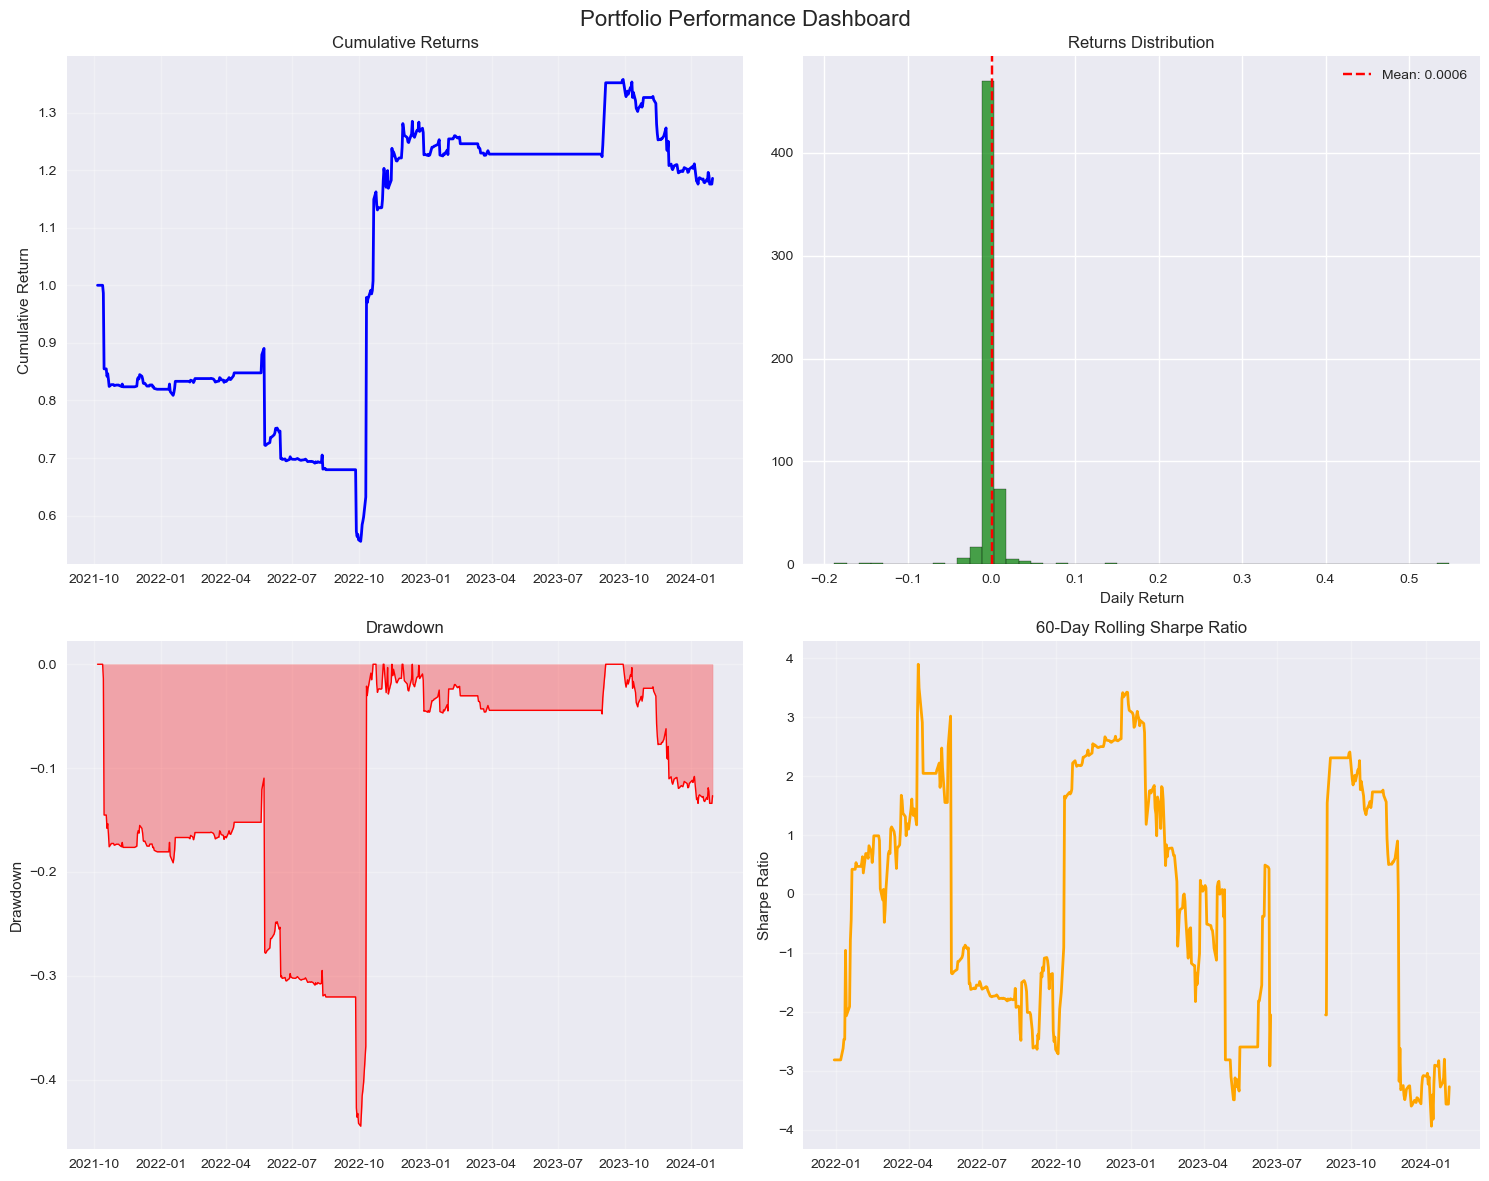

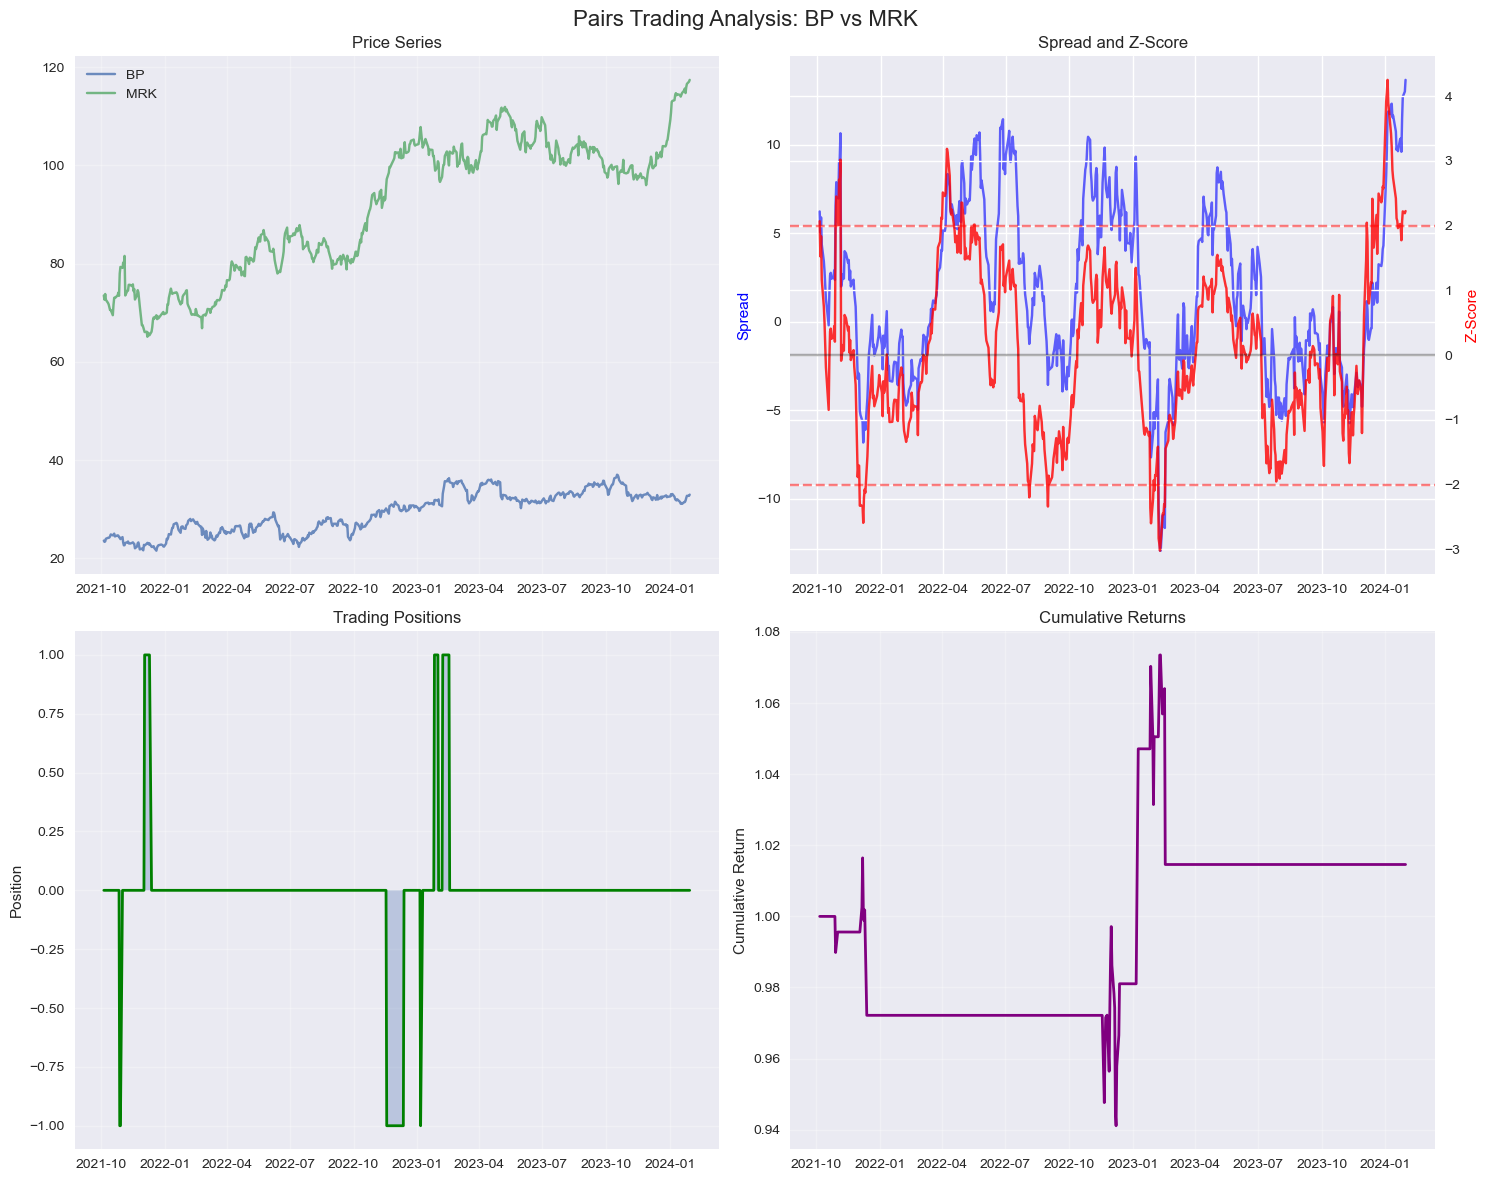


🎉 Strategy execution completed successfully!

📈 ADVANCED PERFORMANCE ANALYSIS REPORT

💹 Return Metrics:
   • Total Return: 18.57%
   • Annualized Return: 16.61%
   • Positive Months: 28.6%

📉 Risk Metrics:
   • Annualized Volatility: 43.67%
   • Max Drawdown: -44.47%
   • Max DD Duration: 257 days
   • VaR (95%): nan%
   • CVaR (95%): nan%

📊 Risk-Adjusted Metrics:
   • Sharpe Ratio: 0.33
   • Sortino Ratio: 0.41
   • Calmar Ratio: 0.00

🎯 Win/Loss Metrics:
   • Win Rate: 28.6%
   • Profit Factor: 1.25


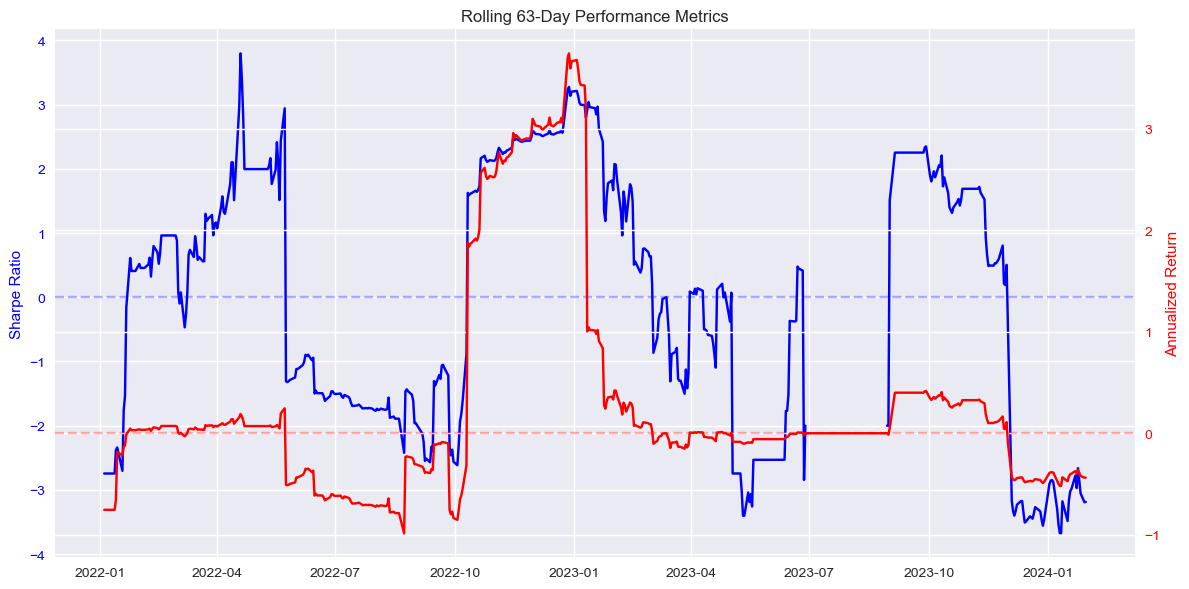

In [107]:
class PerformanceAnalyzer:
    def __init__(self):
        self.risk_free_rate = 0.02  # Assume 2% risk-free rate
        
    def calculate_advanced_metrics(self, returns):
        if len(returns) < 30:
            print("Insufficient data for meaningful analysis")
            return None
            
        # Convert returns to daily if needed
        if isinstance(returns, pd.DataFrame):
            returns = returns.iloc[:,0]
            
        # Basic metrics
        total_return = (1 + returns).prod() - 1
        annualized_return = (1 + returns.mean())**252 - 1
        annualized_vol = returns.std() * np.sqrt(252)
        
        # Risk-adjusted metrics
        sharpe_ratio = (annualized_return - self.risk_free_rate) / annualized_vol if annualized_vol > 0 else 0
        sortino_ratio = self.calculate_sortino(returns)
        calmar_ratio = self.calculate_calmar(returns)
        
        # Drawdown analysis
        max_drawdown, max_dd_duration = self.calculate_drawdown(returns)
        
        # Tail risk
        var_95, cvar_95 = self.calculate_var(returns, alpha=0.05)
        var_99, cvar_99 = self.calculate_var(returns, alpha=0.01)
        
        # Win/loss metrics
        win_rate, profit_factor = self.calculate_win_loss(returns)
        
        metrics = {
            'Total Return': total_return,
            'Annualized Return': annualized_return,
            'Annualized Volatility': annualized_vol,
            'Sharpe Ratio': sharpe_ratio,
            'Sortino Ratio': sortino_ratio,
            'Calmar Ratio': calmar_ratio,
            'Max Drawdown': max_drawdown,
            'Max DD Duration': max_dd_duration,
            'VaR (95%)': var_95,
            'CVaR (95%)': cvar_95,
            'VaR (99%)': var_99,
            'CVaR (99%)': cvar_99,
            'Win Rate': win_rate,
            'Profit Factor': profit_factor,
            'Positive Months': self.positive_month_ratio(returns)
        }
        
        return metrics
    
    def calculate_sortino(self, returns):
        downside_returns = returns[returns < 0]
        downside_vol = downside_returns.std() * np.sqrt(252)
        annualized_return = (1 + returns.mean())**252 - 1
        return (annualized_return - self.risk_free_rate) / downside_vol if downside_vol > 0 else 0
    
    def calculate_calmar(self, returns):
        _, max_drawdown = self.calculate_drawdown(returns)
        annualized_return = (1 + returns.mean())**252 - 1
        return annualized_return / abs(max_drawdown) if max_drawdown != 0 else 0
    
    def calculate_drawdown(self, returns):
        cumulative = (1 + returns).cumprod()
        rolling_max = cumulative.expanding().max()
        drawdown = (cumulative - rolling_max) / rolling_max
        
        # Maximum drawdown
        max_drawdown = drawdown.min()
        
        # Drawdown duration
        drawdown_duration = (drawdown < 0).astype(int)
        max_duration = drawdown_duration.groupby(
            (drawdown_duration != drawdown_duration.shift()).cumsum()
        ).sum().max()
        
        return max_drawdown, max_duration
    
    def calculate_var(self, returns, alpha=0.05):
        if len(returns) < 30:
            return np.nan, np.nan
            
        var = np.percentile(returns, alpha * 100)
        cvar = returns[returns <= var].mean()
        return var, cvar
    
    def calculate_win_loss(self, returns):
        wins = returns[returns > 0]
        losses = returns[returns < 0]
        
        win_rate = len(wins) / len(returns) if len(returns) > 0 else 0
        profit_factor = wins.sum() / abs(losses.sum()) if losses.sum() < 0 else np.inf
        
        return win_rate, profit_factor
    
    def positive_month_ratio(self, returns):
        monthly_returns = returns.resample('M').apply(lambda x: (1 + x).prod() - 1)
        return (monthly_returns > 0).mean()
    
    def plot_rolling_performance(self, returns, window=63):
        fig, ax1 = plt.subplots(figsize=(12, 6))
        
        # Rolling Sharpe
        rolling_sharpe = returns.rolling(window).mean() / returns.rolling(window).std() * np.sqrt(252)
        ax1.plot(rolling_sharpe.index, rolling_sharpe, 'b-', label=f'Rolling {window}-Day Sharpe')
        ax1.set_ylabel('Sharpe Ratio', color='b')
        ax1.tick_params('y', colors='b')
        ax1.axhline(y=0, color='b', linestyle='--', alpha=0.3)
        
        # Rolling Annualized Return
        ax2 = ax1.twinx()
        rolling_annualized = returns.rolling(window).mean() * 252
        ax2.plot(rolling_annualized.index, rolling_annualized, 'r-', label=f'Rolling {window}-Day Annualized Return')
        ax2.set_ylabel('Annualized Return', color='r')
        ax2.tick_params('y', colors='r')
        ax2.axhline(y=0, color='r', linestyle='--', alpha=0.3)
        
        plt.title(f'Rolling {window}-Day Performance Metrics')
        fig.tight_layout()
        plt.show()
    
    def generate_performance_report(self, returns):#Generating comprehensive performance report.
        metrics = self.calculate_advanced_metrics(returns)
        if metrics is None:
            return
            
        print("\n" + "="*60)
        print("📈 ADVANCED PERFORMANCE ANALYSIS REPORT")
        print("="*60)
        
        print("\n💹 Return Metrics:")
        print(f"   • Total Return: {metrics['Total Return']:.2%}")
        print(f"   • Annualized Return: {metrics['Annualized Return']:.2%}")
        print(f"   • Positive Months: {metrics['Positive Months']:.1%}")
        
        print("\n📉 Risk Metrics:")
        print(f"   • Annualized Volatility: {metrics['Annualized Volatility']:.2%}")
        print(f"   • Max Drawdown: {metrics['Max Drawdown']:.2%}")
        print(f"   • Max DD Duration: {metrics['Max DD Duration']} days")
        print(f"   • VaR (95%): {metrics['VaR (95%)']:.2%}")
        print(f"   • CVaR (95%): {metrics['CVaR (95%)']:.2%}")
        
        print("\n📊 Risk-Adjusted Metrics:")
        print(f"   • Sharpe Ratio: {metrics['Sharpe Ratio']:.2f}")
        print(f"   • Sortino Ratio: {metrics['Sortino Ratio']:.2f}")
        print(f"   • Calmar Ratio: {metrics['Calmar Ratio']:.2f}")
        
        print("\n🎯 Win/Loss Metrics:")
        print(f"   • Win Rate: {metrics['Win Rate']:.1%}")
        print(f"   • Profit Factor: {metrics['Profit Factor']:.2f}")
        
        # Plot rolling performance
        self.plot_rolling_performance(returns)
        
        return metrics

# Initialize performance analyzer
performance_analyzer = PerformanceAnalyzer()
print("Performance analysis module initialized")

results = run_complete_strategy()
if results:
    performance_analyzer.generate_performance_report(results['portfolio_returns'])